<a href="https://colab.research.google.com/github/divyaprabhakaran7/Code-Mixed-Spanish-VLM-Study/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Run
!pip install transformers torchvision

In [ ]:
#Run
pip install tqdm

In [ ]:
from PIL import Image
import requests
import torch

from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

print("✅ CLIP model and processor loaded successfully.")

# Test text and dummy image
text = "A happy tweet"
image = Image.new("RGB", (224, 224), color="white")

inputs = processor(text=[text], images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

print("✅ Model forward pass completed.")


✅ CLIP model and processor loaded successfully.
✅ Model forward pass completed.


In [7]:
#Run
import pandas as pd
import torch
import zipfile
from io import BytesIO
from PIL import Image
from IPython.display import display
from transformers import CLIPProcessor, CLIPModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm

# ---- Step 1: Manual File Uploads ----
print("⬆️ Please upload your training CSV, test CSV, and ZIP of images using the upload buttons below.")

import ipywidgets as widgets

upload_train_csv = widgets.FileUpload(accept='.csv', multiple=False, description='Upload Train CSV')
upload_test_csv = widgets.FileUpload(accept='.csv', multiple=False, description='Upload Test CSV')
upload_zip = widgets.FileUpload(accept='.zip', multiple=False, description='Upload Image ZIP')
display(upload_train_csv, upload_test_csv, upload_zip)


⬆️ Please upload your training CSV, test CSV, and ZIP of images using the upload buttons below.


FileUpload(value={}, accept='.csv', description='Upload Train CSV')

FileUpload(value={}, accept='.csv', description='Upload Test CSV')

FileUpload(value={}, accept='.zip', description='Upload Image ZIP')

In [8]:
#Run
# --- Read CSV ---
def get_dataframe(upload_widget):
    for file in upload_widget.value.values():
        content = file['content']
        return pd.read_csv(BytesIO(content))
    return None

# --- Extract images from zip ---
image_dict = {}

def extract_images(upload_widget):
    print("📦 Extracting images from ZIP (with nested folders)...")
    for file in upload_widget.value.values():
        zf = zipfile.ZipFile(BytesIO(file['content']))
        all_files = zf.namelist()
        print(f"Total files in ZIP: {len(all_files)}")
        for full_path in all_files:
            print("  →", full_path)  # 👈 print every file path


# --- Load CLIP ---
print("📥 Loading CLIP model...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("✅ CLIP model and processor loaded.")


📥 Loading CLIP model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP model and processor loaded.


In [ ]:
# --- Extract CLIP features ---
def extract_features(df, text_col='Original English', file_col='file name'):
    features = []
    missing = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        text = row[text_col]
        fname = row[file_col]

        # Text embedding
        text_inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            text_feat = model.get_text_features(**text_inputs)
            text_feat /= text_feat.norm(p=2, dim=-1, keepdim=True)

        # Image embedding
        if fname in image_dict:
            image = image_dict[fname]
            image_inputs = processor(images=image, return_tensors="pt")
            with torch.no_grad():
                image_feat = model.get_image_features(**image_inputs)
                image_feat /= image_feat.norm(p=2, dim=-1, keepdim=True)
        else:
            image_feat = torch.zeros_like(text_feat)
            missing += 1

        combined = torch.cat([text_feat, image_feat], dim=1).squeeze().numpy()
        features.append(combined)

    if missing > 0:
        print(f"⚠️ {missing} images were missing.")
    return features


In [6]:
#Run, upload .zip
from google.colab import files

# Upload training CSV, test CSV, and ZIP of images
uploaded = files.upload()

Saving Images.zip to Images.zip


In [13]:
#Run
def custom_collate(batch):
    texts = [item[0]["input_ids"] for item in batch]
    masks = [item[0]["attention_mask"] for item in batch]
    images = [item[0]["pixel_values"] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    # Pad input_ids and attention_mask
    input_ids = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    pixel_values = torch.stack(images)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values
    }, labels


In [43]:
#Run
import zipfile
from PIL import Image

image_dict = {}
zip_path = "Images.zip"

with zipfile.ZipFile(zip_path, 'r') as zf:
    for full_path in zf.namelist():
        # Skip junk files from macOS
        if ('__MACOSX' in full_path or '/._' in full_path or full_path.startswith('._')):
            continue

        if full_path.lower().endswith(('.jpg', '.jpeg', '.png')) and not full_path.endswith('/'):
            filename = full_path.split('/')[-1].strip().lower()
            try:
                with zf.open(full_path) as img_file:
                    img = Image.open(img_file).convert("RGB")
                    image_dict[filename] = img
            except Exception as e:
                print(f"❌ Could not load {filename}: {e}")

print(f"✅ Loaded {len(image_dict)} images.")
print("📂 Sample image keys:", list(image_dict.keys())[:5])


✅ Loaded 4869 images.
📂 Sample image keys: ['63.jpg', '4217.jpg', '2100.jpg', '4565.jpg', '77.jpg']


In [44]:
train_df = get_dataframe(upload_train_csv)
print("Sample filenames from CSV:", train_df['file name'].unique()[:10])

test_df = get_dataframe(upload_test_csv)
extract_images(upload_zip)
print("Sample image filenames loaded:", list(image_dict.keys())[:10])

# Normalize filenames in the CSV
train_df['file name'] = train_df['file name'].str.strip().str.lower()
test_df['file name'] = test_df['file name'].str.strip().str.lower()

print("🧠 Extracting features from training data...")
X_train = extract_features(train_df)
y_train = train_df['label'].tolist()

print("🧪 Extracting features from test data...")
X_test = extract_features(test_df)
y_test = test_df['label'].tolist()

print("🔧 Training classifier...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

print("📈 Predicting...")
y_pred = clf.predict(X_test)

print("\n📊 Sentiment Classification Report:")
print(classification_report(y_test, y_pred))


Sample filenames from CSV: ['100.jpg' '1001.jpg' '1002.jpg' '1009.jpg' '1018.jpg' '102.jpg'
 '1020.jpg' '1023.jpg' '1024.jpg' '1030.jpg']
📦 Extracting images from ZIP (with nested folders)...
Sample image filenames loaded: ['63.jpg', '4217.jpg', '2100.jpg', '4565.jpg', '77.jpg', '1353.jpg', '1421.jpg', '1390.jpg', '2841.jpg', '162.jpg']
🧠 Extracting features from training data...


Extracting features: 100%|██████████| 3213/3213 [17:56<00:00,  2.99it/s]


🧪 Extracting features from test data...


Extracting features: 100%|██████████| 804/804 [04:38<00:00,  2.89it/s]


🔧 Training classifier...
📈 Predicting...

📊 Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.73      0.66       268
     neutral       0.50      0.37      0.42       268
    positive       0.61      0.64      0.62       268

    accuracy                           0.58       804
   macro avg       0.57      0.58      0.57       804
weighted avg       0.57      0.58      0.57       804



In [2]:
#Run
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile
from io import BytesIO
from tqdm import tqdm

In [3]:
#Run
class CLIPSentimentClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip = clip_model
        for param in self.clip.parameters():
            param.requires_grad = False  # freeze CLIP
        self.classifier = nn.Linear(512 * 2, num_classes)

    def forward(self, inputs):
        text_feat = self.clip.get_text_features(input_ids=inputs["input_ids"],
                                                attention_mask=inputs["attention_mask"])
        text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True)

        image_feat = self.clip.get_image_features(pixel_values=inputs["pixel_values"])
        image_feat = image_feat / image_feat.norm(p=2, dim=-1, keepdim=True)

        combined = torch.cat([text_feat, image_feat], dim=1)
        return self.classifier(combined)


In [11]:
#Run
class CLIPDataset(Dataset):
    def __init__(self, dataframe, processor, label_encoder):
        self.df = dataframe
        self.processor = processor
        self.label_encoder = label_encoder
        self.labels = label_encoder.transform(self.df['label'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Original English']
        fname = row['file name']
        image = image_dict.get(fname, Image.new("RGB", (224, 224), color='white'))

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx])
        return inputs, label


In [14]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#Run
train_df = get_dataframe(upload_train_csv)
test_df = get_dataframe(upload_test_csv)

# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Create DataLoader
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

dataset = CLIPDataset(train_df, processor, label_encoder)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

# Model
model = CLIPSentimentClassifier(clip_model, num_classes=len(label_encoder.classes_)).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"🔥 Epoch {epoch+1} Loss: {total_loss:.4f}")


Epoch 1/5: 100%|██████████| 201/201 [12:13<00:00,  3.65s/it]


🔥 Epoch 1 Loss: 220.6215


Epoch 2/5: 100%|██████████| 201/201 [12:04<00:00,  3.60s/it]


🔥 Epoch 2 Loss: 219.9483


Epoch 3/5: 100%|██████████| 201/201 [12:05<00:00,  3.61s/it]


🔥 Epoch 3 Loss: 219.3112


Epoch 4/5: 100%|██████████| 201/201 [13:02<00:00,  3.89s/it]


🔥 Epoch 4 Loss: 218.7048


Epoch 5/5: 100%|██████████| 201/201 [12:03<00:00,  3.60s/it]

🔥 Epoch 5 Loss: 218.1051


In [16]:
#Run
class CLIPTestDataset(Dataset):
    def __init__(self, dataframe, processor, label_encoder):
        self.df = dataframe
        self.processor = processor
        self.label_encoder = label_encoder
        self.labels = label_encoder.transform(self.df['label'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Original English']
        fname = row['file name']
        image = image_dict.get(fname, Image.new("RGB", (224, 224), color='white'))

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx])
        return inputs, label


In [17]:
#Run
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Setup
test_df['file name'] = test_df['file name'].str.strip().str.lower()
test_df['label'] = test_df['label'].str.strip().str.lower()

test_dataset = CLIPTestDataset(test_df, processor, label_encoder)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate)

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to original label names
y_true = label_encoder.inverse_transform(all_labels)
y_pred = label_encoder.inverse_transform(all_preds)

# Show metrics
print("✅ Evaluation Complete\n")
print(classification_report(y_true, y_pred, digits=3))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Macro:", f1_score(y_true, y_pred, average='macro'))
print("F1 Weighted:", f1_score(y_true, y_pred, average='weighted'))


Evaluating: 100%|██████████| 51/51 [03:16<00:00,  3.85s/it]

✅ Evaluation Complete

              precision    recall  f1-score   support

    negative      0.490     0.705     0.578       268
     neutral      0.445     0.272     0.338       268
    positive      0.610     0.578     0.594       268

    accuracy                          0.519       804
   macro avg      0.515     0.519     0.503       804
weighted avg      0.515     0.519     0.503       804

Accuracy: 0.5186567164179104
F1 Macro: 0.503271448713292
F1 Weighted: 0.503271448713292


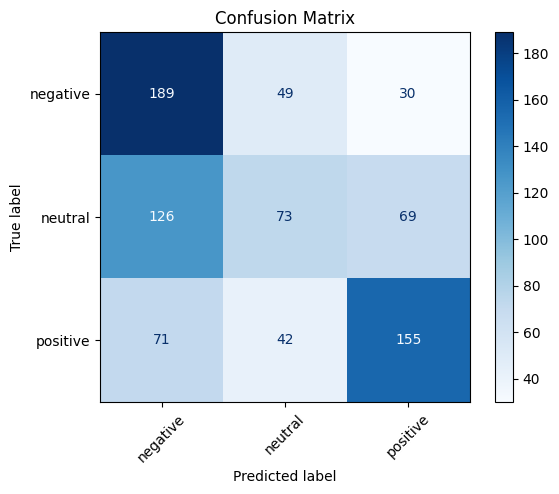

In [18]:
#Run
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
